# Upload dataset
https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images

In [ ]:
from google.colab import files
files.upload()
# !kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
# import zipfile

# with zipfile.ZipFile("cifake-real-and-ai-generated-synthetic-images.zip", "r") as zip_ref:
#     zip_ref.extractall("/content/cifake")  # Extract dataset here
# data_dir_train = "/content/cifake/train"
# data_dir_test = "/content/cifake/test"

Saving ai1.png to ai1.png
Saving test1.jpg to test1.jpg
Saving test3.png to test3.png
Saving trip1.jpg to trip1.jpg
Saving trip3.jpg to trip3.jpg
Saving trip5.jpg to trip5.jpg
Buffered data was truncated after reaching the output size limit.

https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
import numpy as np
import tensorflow as tf

## Train Dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,  # Path to the directory containing 'FAKE' and 'REAL'
    label_mode="binary",  # If there are only two classes (FAKE/REAL)
    image_size=(32, 32),  # Resize images to 32x32
    batch_size=32  # Batch size for training
)

Found 100000 files belonging to 2 classes.


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

Batch shape: (32, 256, 256, 3)
Labels shape: (32, 1)


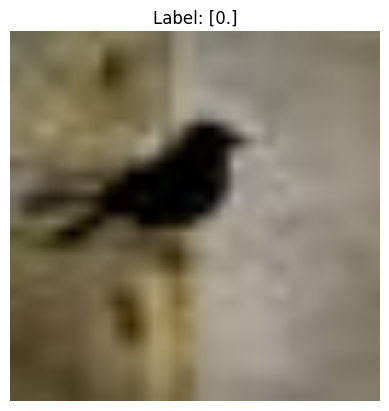

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
image_batch, label_batch = next(iter(train_ds))

# Show the shape of the data
print("Batch shape:", image_batch.shape)  # (batch_size, height, width, channels)
print("Labels shape:", label_batch.shape)  # (batch_size,)

# Display the first image in the batch
plt.imshow(image_batch[0].numpy().astype("uint8"))
plt.title(f"Label: {label_batch[0].numpy()}")
plt.axis("off")
plt.show()

In [ ]:
print("Class names:", train_ds.class_names)

Class names: ['FAKE', 'REAL']


Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 1)


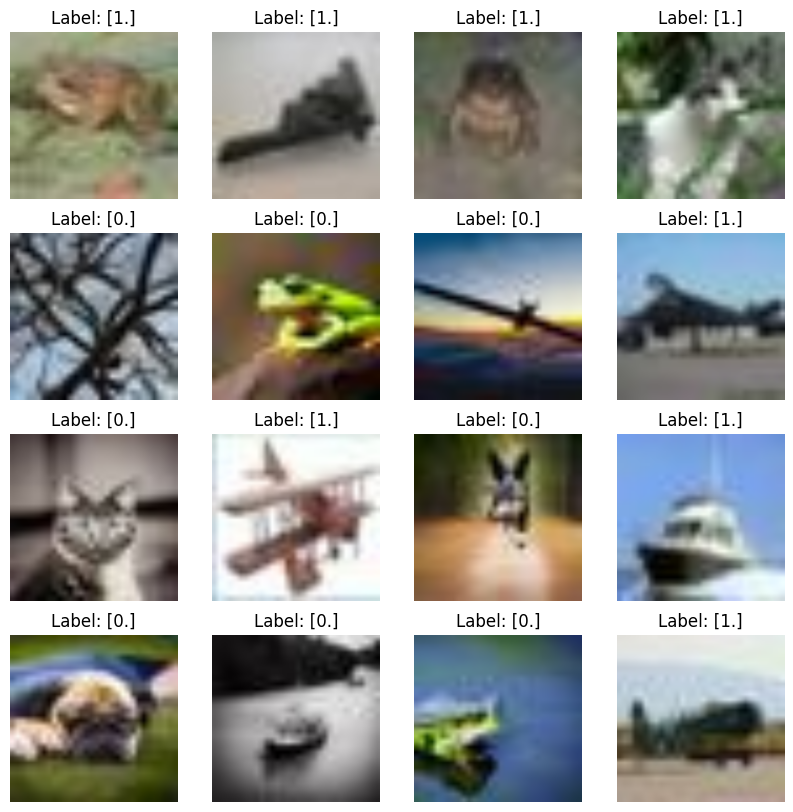

In [ ]:
for images, labels in train_ds.take(1):  # Take only 1 batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

    # Show multiple images from the batch
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(f"Label: {labels[i].numpy()}")
        ax.axis("off")

    plt.show()

## Test Dataset

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    label_mode="binary",
    image_size=(128, 128),
    batch_size=32,
)

Found 20000 files belonging to 2 classes.


In [ ]:
print("Class names:", test_ds.class_names)

Class names: ['FAKE', 'REAL']


# Iterate on your CNN architecture using your small training set

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization

def initialize_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128,128, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))


    return model

In [ ]:
model = initialize_model()
print(model.layers[-1].get_config())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


{'name': 'dense_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.losses import BinaryCrossentropy


def compile_model(model):
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", Precision(), Recall(), AUC()]
    )
    return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
es = EarlyStopping(patience = 15, monitor ='val_loss', restore_best_weights=True)

In [ ]:
model = initialize_model()
model = compile_model(model)
history = model.fit(train_ds, validation_data=test_ds, epochs = 100, batch_size = 32, callbacks = [es, lr_scheduler])

Epoch 1/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 165s 48ms/step - accuracy: 0.8406 - auc_2: 0.9153 - loss: 0.3654 - precision_2: 0.8386 - recall_2: 0.8430 - val_accuracy: 0.9364 - val_auc_2: 0.9826 - val_loss: 0.1699 - val_precision_2: 0.9295 - val_recall_2: 0.9444 - learning_rate: 0.0010
Epoch 2/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 148s 47ms/step - accuracy: 0.9281 - auc_2: 0.9783 - loss: 0.1868 - precision_2: 0.9303 - recall_2: 0.9253 - val_accuracy: 0.9406 - val_auc_2: 0.9852 - val_loss: 0.1541 - val_precision_2: 0.9482 - val_recall_2: 0.9320 - learning_rate: 0.0010
Epoch 3/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 203s 48ms/step - accuracy: 0.9386 - auc_2: 0.9837 - loss: 0.1607 - precision_2: 0.9411 - recall_2: 0.9355 - val_accuracy: 0.9528 - val_auc_2: 0.9901 - val_loss: 0.1251 - val_precision_2: 0.9522 - val_recall_2: 0.9535 - learning_rate: 0.0010
Epoch 4/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 146s 47ms/step - accuracy: 0.9475 - auc_2: 0.9872 - loss: 0.1411 - precision_2: 0.9491 - recall_2: 0.9454

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 0.5)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.8, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

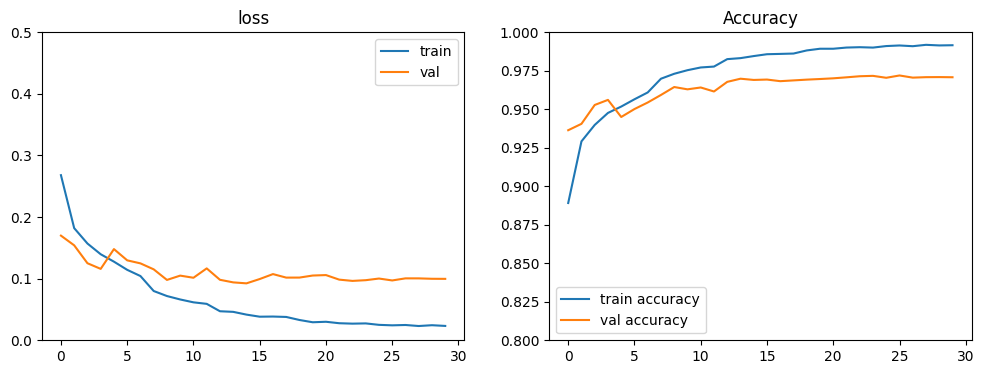

In [ ]:
plot_history(history, title='', axs=None, exp_name="")

In [ ]:
model.evaluate(test_ds, return_dict=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9696 - auc_2: 0.9940 - loss: 0.0885 - precision_2: 0.9716 - recall_2: 0.9675


{'accuracy': 0.9690499901771545,
 'auc_2': 0.9939157366752625,
 'loss': 0.09241261333227158,
 'precision_2': 0.9715492129325867,
 'recall_2': 0.9664000272750854}

In [ ]:
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

In [ ]:
model.save('/content/baseline_128image.keras')

In [ ]:
# from google.colab import files
# files.download('/content/baseline_image.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import tensorflow as tf
foo= tf.keras.models.load_model("/home/romaric/code/nghia95/fake-data-detector/notebooks/roma_utils/roma_models/baseline_image.keras")

ValueError: File not found: filepath=/home/romaric/code/nghia95/fake-data-detector/notebooks/roma_utils/roma_models/baseline_image.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
foo.evaluate(test_ds,return_dict=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9690 - auc_1: 0.9942 - loss: 0.0915 - precision_1: 0.9611 - recall_1: 0.9768


{'accuracy': 0.9692999720573425,
 'auc_1': 0.9944639205932617,
 'loss': 0.08971156924962997,
 'precision_1': 0.9627292156219482,
 'recall_1': 0.9764000177383423}

# Try other images

In [1]:
foo= tf.keras.models.load_model("baseline_image.keras")

NameError: name 'tf' is not defined

In [ ]:
from google.colab import files
files.upload()

Saving baseline_image.keras to baseline_image.keras


In [ ]:
# Load one image
image_path = "test1.jpg"
img = tf.keras.utils.load_img(
    image_path, target_size=(32, 32)
)



OSError: image file is truncated (46 bytes not processed)

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)


In [ ]:
predictions = foo.predict(img_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [ ]:
predictions

array([[0.00164112]], dtype=float32)

NOTES: Error on test 2 (face on the side) <br>
        test 3 zoomed ID picture test3<br>
        trip 1 (martin crazy car)<br>
        trip3 zoom on hand (wedding)<br>
        trip4 jindezheng excavation<br>
        trip5 pose<br>
        trip6 greece landscape
